In [112]:
from feature_engine.discretisers import EqualWidthDiscretiser, EqualFrequencyDiscretiser, UserInputDiscretiser
from datetime import datetime

from sklearn import preprocessing
import matplotlib.pyplot as plt
import pandas as pd

pd.set_option('display.max_columns', None) # Print all columns to jupyter notebook

DATA_PATH = r'../data/credit.csv'
DATA_OUTPUT = r'../data/credit_output.csv'

df = pd.read_csv(DATA_PATH)

BIN_VALUES = True
if BIN_VALUES:
    DATA_OUTPUT = r'../data/credit_output_binned.csv'
    

"""
Remove bad data - Quick removal of rows that contain garbage data
"""
# Remove where rows are almost entirely empty
df = df[df['location'] != '?'] # removes 2 rows
df = df[df['checking_amt'] != '?'] # removes 1 row



"""
Value renaming - structural modifications to data
"""

df['state'] = df['state'].replace('Rhodes Island', 'Rhode Island')

# 'location'
# Remove state abbrv in location. It is already stored in 'state' column
# and has been verified all rows have matching abbrv's and state columns.
df['location'] = df['location'].str.replace('District of Columbia', 'District of Columbia, DC')
df['location'] = df['location'].str.replace('Prince George\'s', 'Prince George')
df['location'] = df['location'].str.split(', ').apply(lambda x: x[0])

# 'property_magnitude'
# Replace the ?s with other and make format consistent.
df['property_magnitude'] = df['property_magnitude'].mask(df['property_magnitude'] == "?", "no known property")
df['property_magnitude'].replace("'(.*?)'", "\\1", inplace=True, regex=True)

# 'class', 'foreign_worker', 'works_outside_US'
# Make positive and negative values consistent
# df['works_outside_US'].replace(['^(1|[Yy]).*', '^(0|[Nn]).*'], ['YES', 'NO'], inplace=True, regex=True)
df['foreign_worker'].replace(['^(1|[Yy]).*', '^(0|[Nn]).*'], ['YES', 'NO'], inplace=True, regex=True)
df['class'].replace(['^([Gg]).*', '^([Bb]).*'], ['GOOD', 'BAD'], inplace=True, regex=True)


# 'employment'
# Replacing missing employment values with unknown
df['employment'] = df['employment'].mask(df['employment'] == "?", "unknown")
df['employment'].replace(['unknown', 'unemployed', '<1', '1<=X<4', '4<=X<7', '>=7'],
                         [0, 0, 1, 2, 3, 4],
                         inplace=True)


# 'personal_status'
# Replacing missing personal_status values with unknown
df['personal_status'] = df['personal_status'].mask(df['personal_status'] == "?", "unknown")
# Remove the single quotes around the data
df['personal_status'].replace("'(.*?)'", "\\1", inplace=True, regex=True)


# 'other_parties'
# Replacing missing other_parties values with unknown
df['other_parties'] = df['other_parties'].mask(df['other_parties'] == "?", "unknown")
# Remove the single quotes around the data
df['other_parties'].replace("'(.*?)'", "\\1", inplace=True, regex=True)


# 'purpose'
# Replacing missing other_parties values with unknown
df['purpose'] = df['purpose'].mask(df['purpose'] == "?", "other")
# Remove the single quotes around the data
df['purpose'].replace("'(.*?)'", "\\1", inplace=True, regex=True)


# 'job'
# Replacing missing other_parties values with unknown
df['job'].mask(df['job'] == "?", "unknown", inplace=True)
# Remove the single quotes around the data
df['job'].replace("'(.*?)'", "\\1", inplace=True, regex=True)

# 'credit_history'
# Replacing missing credit_history values with unknown
df['credit_history'] = df['credit_history'].mask(df['credit_history'] == "?", "unknown")
# Remove the single quotes around the data
df['credit_history'].replace("'(.*?)'", "\\1", inplace=True, regex=True)

# TEST, reduce categories
df['credit_history'].replace(['existing paid', 'all paid'], 'Good', inplace=True)
df['credit_history'].replace(['delayed previously', 'unknown', 'no credits/all paid'], 'Moderate', inplace=True)
df['credit_history'].replace(['critical/other existing credit'], 'Bad', inplace=True)


# 'other_payment_plans'
# Replacing missing other_payment_plans values with unknown
df['other_payment_plans'] = df['other_payment_plans'].mask(df['other_payment_plans'] == "?", "unknown")
# Remove the single quotes around the data
df['other_payment_plans'].replace("'(.*?)'", "\\1", inplace=True, regex=True)

# 'housing'
# Replacing missing housing values with unknown
df['housing'] = df['housing'].mask(df['housing'] == "?", "unknown")
# Remove the single quotes around the data
df['housing'].replace("'(.*?)'", "\\1", inplace=True, regex=True)

# Replacing missing own_telephone values with unknown
df['own_telephone'] = df['own_telephone'].mask(df['own_telephone'] == "?", "unknown")
# Remove the single quotes around the data
df['own_telephone'].replace("'(.*?)'", "\\1", inplace=True, regex=True)



"""
Value manipulation - semantic modifications to data
"""




# 'checking_amt'
# Bin into 10 equal width bins
df['checking_amt'] = df['checking_amt'].apply(float) # Stored as strings originally
df = df[df['checking_amt'].isna() != True] # removes 1 row



    

# 'age'
median = df[df['age'] != '?']['age'].apply(int).median()
df['age'].mask(df['age'] == "?", median, inplace=True)
df['age'] = df['age'].apply(int)
df = df[df['age'].between(0, 100)]


# 'num_dependents'
# Set ?'s to median value, remove unrealistic values
median = df[df['num_dependents'] != '?']['num_dependents'].apply(int).median()
df['num_dependents'].mask(df['num_dependents'] == "?", median, inplace=True)
df['num_dependents'] = df['num_dependents'].apply(int)
df = df[df['num_dependents'].between(0, 5)]

# 'duration'
# Calculate the median of duration and replace missing values with it
median = df[df['duration'] != '?']['duration'].apply(float).median()
df['duration'].mask(df['duration'] == "?", median, inplace=True)
# Convert duration values to float
df['duration'] = df['duration'].apply(float)


# 'installment_commitment'
# Replacing missing installment_commitment values with -1
df['installment_commitment'] = df['installment_commitment'].mask(df['installment_commitment'] == "?", "-1")
df['installment_commitment'] = df['installment_commitment'].apply(int)

# 'residence_since'
# Replacing missing residence_since values with -1
df['residence_since'] = df['residence_since'].mask(df['residence_since'] == "?", "-1")
df['residence_since'] = df['residence_since'].apply(int)

# 'existing_credits'
# Replacing missing existing_credits values with -1
df['existing_credits'] = df['existing_credits'].mask(df['existing_credits'] == "?", "-1")
df['existing_credits'] = df['existing_credits'].apply(int)

# 'savings'
# Calculate the median of savings and replace missing values with it
median = df[df['savings'] != '?']['savings'].apply(float).median()
df['savings'].mask(df['savings'] == "?", median, inplace=True)
# Convert savings values to float
df['savings'] = df['savings'].apply(float)
# Bin by frequency


# 'credit_amount'
# Grab the credit_amount column without ?s
no_miss_credit = df[df['credit_amount'] != "?"]
# Convert to integer
no_miss_credit = no_miss_credit.astype({"credit_amount": float})
# Remove outliers and then calculate the average value
median = float(no_miss_credit['credit_amount'].median())

# Remove all ?s with the calculate average, also remove the outliers again
df['credit_amount'] = df['credit_amount'].mask(df['credit_amount'] == "?", f"{median}")
df = df.astype({"credit_amount": float})


"""
Feature creation - Using other attributes to define new features
"""
df['total'] = df['checking_amt'] + df['savings'] + df['credit_amount']
df['proportion'] = (df['checking_amt'] + df['savings']) / (df['credit_amount'] + 1)
import re
pattern = re.compile('(?P<gender>^male|^female|unknown).*')
df['gender'] = df['personal_status'].apply(lambda x: pattern.match(x).group('gender'))



"""

"""
# Removes verified as it only has 5 entries and will serve as noise more than anything else
del df['verified']
del df['location'] # This mostly just caused overfitting, not particularly relevant
del df['application_date'] # The range of time (3-years) this data consists of is not large enough to make a meaningful trend
                           # We originally tried seperating year/month but was not making a meaningful difference in the classifiers

# After running chi squared analysis on the nominal attributes:
# We noticed that 'works_outside_US' correlated 100% with 'foreign_worker'
del df['works_outside_US']



        
"""
Binning - Making numerical data categorical
"""
if BIN_VALUES:
    user_discretiser = UserInputDiscretiser(
        binning_dict={'age': [0, 15, 25, 40, 65, 120],
                      'savings': [-100, 100, 100000],
                      'proportion': [-1000,-2,0,2,1000]
                     },
    )
    freq_discretiser = EqualFrequencyDiscretiser(
        q=10,
        variables=['checking_amt', 'credit_amount', 'duration', 'total']
    )
    df = user_discretiser.fit_transform(df)
    df = freq_discretiser.fit_transform(df)
        
       


"""
Output data - Make cleaned data usable for other applications
"""
# Output to CSV

# Set decision attribute in last column
class_ = df['class']
del df['class']
df.insert(len(df.columns), 'class', class_)

df.to_csv(DATA_OUTPUT, index=False)




In [54]:
df[(df['class'] == 'GOOD') & (df['credit_history'] == 'Good')].shape[0] + df[(df['class'] == 'BAD') & (df['credit_history'] == 'Bad')].shape[0]

423

In [109]:
df

,state,checking_amt,duration,credit_history,purpose,credit_amount,savings,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,total,proportion,gender,class
0,Pennsylvania,1,0,Bad,radio/tv,4,0,4,-1,male single,none,4,real estate,4,none,own,2,skilled,1,yes,NO,1,1,male,BAD
1,Pennsylvania,4,7,Good,radio/tv,8,0,2,2,female div/dep/mar,none,2,no known property,1,none,own,1,skilled,1,none,NO,8,2,female,BAD
2,Pennsylvania,2,1,Bad,education,3,0,3,2,male single,unknown,-1,real estate,3,none,unknown,1,unskilled resident,2,none,NO,4,1,male,BAD
3,Pennsylvania,1,7,Good,furniture/equipment,9,0,3,2,male single,guarantor,4,life insurance,3,none,for free,1,skilled,2,unknown,NO,6,1,male,BAD
4,Pennsylvania,0,4,Moderate,other,8,0,2,3,male single,none,4,no known property,3,none,for free,2,skilled,2,none,NO,0,1,male,GOOD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999,New York,2,1,Good,furniture/equipment,3,0,3,3,unknown,none,4,real estate,2,none,own,1,unskilled resident,1,none,NO,4,1,unknown,BAD
1000,New York,1,6,Good,other,7,0,2,4,male div/sep,none,4,life insurance,2,none,own,1,high qualif/self emp/mgmt,1,yes,YES,1,1,male,GOOD
1001,Ohio,2,2,Good,radio/tv,0,0,4,4,male single,unknown,4,car,2,none,own,1,skilled,1,none,NO,2,1,male,GOOD
1002,Ohio,0,7,Good,radio/tv,3,0,2,4,male single,unknown,-1,no known property,1,none,for free,1,skilled,1,yes,YES,0,0,male,GOOD


<AxesSubplot:>

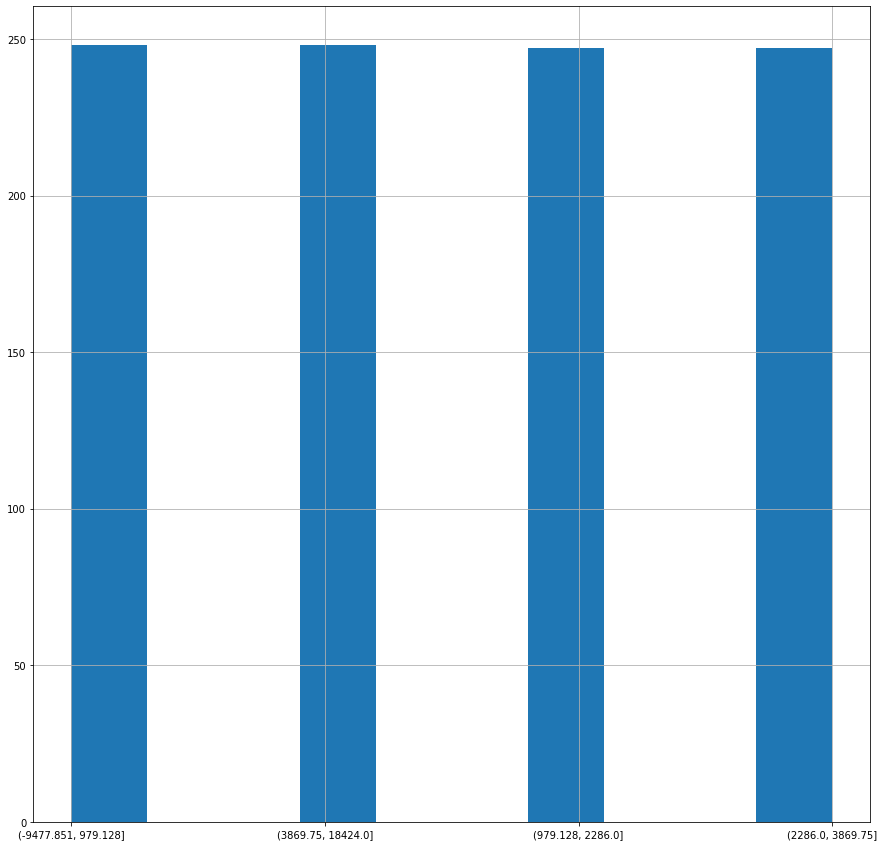

In [81]:
df['total_b'].hist(figsize=(15,15))

In [28]:
ef = pd.DataFrame(columns=df.columns)
ef['age'] = pd.Series(list(range(100)))
ef['age']
user_discretiser.transform(ef)['age'].value_counts()


4.0    34
3.0    25
2.0    15
0.0    15
1.0    10
Name: age, dtype: int64

In [50]:
df['purpose'].value_counts()

radio/tv               247
new car                211
furniture/equipment    166
other                  110
used car                90
business                83
education               45
repairs                 20
domestic appliance      11
retraining               7
Name: purpose, dtype: int64